Test the new pcolormesh algorithm

In [1]:
from datetime import datetime
import timeit
    
import matplotlib.pyplot as plt
import numpy as np
import asilib.map
import asilib
from asilib.asi.trex import trex_rgb

Current implementation

plot_map time 3.23


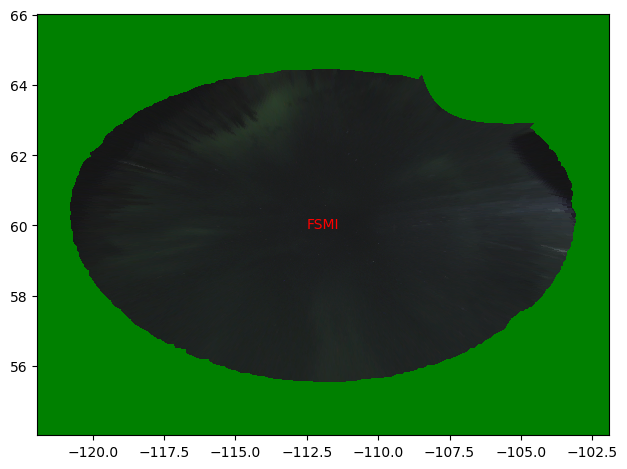

In [11]:
time = datetime(2021, 11, 4, 7, 3, 51)
asi = trex_rgb('FSMI', time=time)
ax = asilib.map.create_simple_map(
    lon_bounds=(asi.meta['lon']-10, asi.meta['lon']+10),
    lat_bounds=(asi.meta['lat']-6, asi.meta['lat']+6)
)
start = timeit.default_timer()
asi.plot_map(ax=ax)
print(f'plot_map time {timeit.default_timer()-start:.2f}')
plt.tight_layout()

New implementation

In [ ]:
class Clean_Skymap:
    def __init__(self, lon_grid, lat_grid, el_grid, min_elevation=None):
        """
        Clean the skymap by applying two steps: 1) Mask the lon_grid and lat_grid
        variables with np.nan if they are below min_elevation, and 2) replace all
        np.nan values in lon_grid, lat_grid with the closest valid value.
        """
        # Copy variables to not modify original np.arrays.
        self._lon_grid = lon_grid.copy()
        self._lat_grid = lat_grid.copy()
        self._el_grid = el_grid
        self.min_elevation = min_elevation
        if self.min_elevation is not None:
            self.mask_elevation()
        return
    
    def _mask_elevation(self):
        """
        Mask low elevation pixels.
        """
        if self._el_grid.shape == self._lon_grid.shape:
            idh = np.where(np.isnan(self._el_grid) | (self._el_grid < self.min_elevation))
        elif (self._el_grid.shape[0]+1 == self._lon_grid.shape[0]) and (self._el_grid.shape[1]+1 == self._lon_grid.shape[1]):
            # If the lat/lon grid is defined at pixel vertices while the el grid defines the pixel centers.
            # Here we will pretend that the el_grid is defined at pixel vertices by appending one row and column
            _el_grid = self._el_grid.copy()
            _el_grid = np.append(_el_grid, _el_grid[-1, :], axis=0)
            _el_grid = np.append(_el_grid, _el_grid[:, -1], axis=1)
            idh = np.where(np.isnan(self._el_grid) | (self._el_grid < self.min_elevation))
        else:
            raise ValueError(
                f'Can not apply elevation mask to lat/lon skymap with shape {self._lon_grid.shape} and'
                f'the elevation skymap shape {self._el_grid.shape}. The shapes must be equal or the '
                f'elevation skymap must be one less than the lon_grid.'
                )
        self._lon_grid[idh] = np.nan
        self._lat_grid[idh] = np.nan
        return

    def remove_nans(self):
        if np.any(~np.isfinite(lon_grid_copy)) or np.any(~np.isfinite(lat_grid_copy)):
            # Since pcolormesh can't handle any nan values in the x or y arrays,
            # this algorithm removes them. It loops over grid angle pairs 
            # (e.g. (0, 10), (10, 20), ...), finds the points in x & y that are
            # between those angles, and reassigns those invalid values to the 
            # valid point with the lowest elevation in that segment.
            center_index = np.unravel_index(np.nanargmax(el_grid), el_grid.shape)

            angles = np.linspace(0, 2*np.pi, num=300)
            # We need to set up 2 sets of grids since U Calgary's (lat, lon) skymap
            # dimentions are 1 greater than the (elevation, azimuth) skymaps.
            xx_geodetic, yy_geodetic = np.meshgrid(
                np.arange(lon_grid_copy.shape[0]), 
                np.arange(lon_grid_copy.shape[1]), 
                indexing='ij'  # So that the shapes of x, y, xx, and yy are the same.
                )
            xx_elevation, yy_elevation = np.meshgrid(
                np.arange(el_grid.shape[0]), 
                np.arange(el_grid.shape[1]), 
                indexing='ij'  # So that the shapes of x, y, xx, and yy are the same.
                )
            
            for start_angle, end_angle in zip(angles[:-1], angles[1:]):
                # These if-else blocks are probably causing the angular sliver bug which is 
                # patched below.
                if (start_angle < np.pi/2) or (start_angle > 3*np.pi/2):
                    start_slope_sign = 1
                else:
                    start_slope_sign = -1
                if (end_angle < np.pi/2) or (end_angle > 3*np.pi/2):
                    end_slope_sign = 1
                else:
                    end_slope_sign = -1
        
                start_slope = start_slope_sign*np.tan(start_angle)
                start_y_int = center_index[1] - start_slope*center_index[0]
                end_slope = end_slope_sign*np.tan(end_angle)
                end_y_int = center_index[1] - end_slope*center_index[0]

                geodetic_slice_invalid_indices = np.where(
                        (yy_geodetic >= start_slope*xx_geodetic + start_y_int) &
                        (yy_geodetic <= end_slope*xx_geodetic + end_y_int) &
                        (np.isnan(lon_grid_copy) | np.isnan(lat_grid_copy))
                    )

                if lat_grid_copy.shape == el_grid.shape:
                    elevation_slice_valid_indices = np.where(
                        (yy_elevation > start_slope*xx_elevation + start_y_int) &
                        (yy_elevation < end_slope*xx_elevation + end_y_int) &
                        np.isfinite(el_grid) & 
                        np.isfinite(lon_grid_copy) &
                        np.isfinite(lat_grid_copy)
                    )
                else:
                    elevation_slice_valid_indices = np.where(
                        (yy_elevation > start_slope*xx_elevation + start_y_int) &
                        (yy_elevation < end_slope*xx_elevation + end_y_int) &
                        np.isfinite(el_grid) & 
                        np.isfinite(lon_grid_copy[:-1, :-1]) &
                        np.isfinite(lat_grid_copy[:-1, :-1])
                    )
                min_el_slice_index = np.argmin(el_grid[elevation_slice_valid_indices])
                lon_grid_copy[geodetic_slice_invalid_indices] = lon_grid_copy[
                    elevation_slice_valid_indices[0][min_el_slice_index],
                    elevation_slice_valid_indices[1][min_el_slice_index]
                    ]
                lat_grid_copy[geodetic_slice_invalid_indices] = lat_grid_copy[
                    elevation_slice_valid_indices[0][min_el_slice_index],
                    elevation_slice_valid_indices[1][min_el_slice_index]
                    ]
            # The following section is a patch for the small angular sliver of points
            # that the method misses. I am trying a quick and dirty approach first to determine 
            # if this approach even works.
            invalid_idxs = np.where(np.isnan(lon_grid_copy) | np.isnan(lat_grid_copy))
            valid_indices = np.where(np.isfinite(lon_grid_copy) & np.isfinite(lat_grid_copy))
            for invalid_idx in zip(*invalid_idxs):
                min_valid_idx_flattened = np.nanargmin(
                    (invalid_idx[0]-xx_geodetic[valid_indices])**2 + (invalid_idx[1]-yy_geodetic[valid_indices])**2
                    )
                closest_valid_idx = (
                    valid_indices[0][min_valid_idx_flattened], 
                    valid_indices[1][min_valid_idx_flattened]
                    )
                lat_grid_copy[invalid_idx] = lat_grid_copy[closest_valid_idx]
                lon_grid_copy[invalid_idx] = lon_grid_copy[closest_valid_idx]
                    
            if np.any(~np.isfinite(lon_grid_copy)) or np.any(~np.isfinite(lat_grid_copy)):
                raise ValueError(
                    'Either the lat or lon skymap still contains invalid values '
                    '(nans are not allowed).'
                    )
        return lon_grid_copy, lat_grid_copy